# ICCS Collaboration Network Study

This notebook constructs a longitudinal co-authorship network from OpenAlex data
and identifies different types of ICCS-related emergent collaborations.

All collaborations are defined at the author-pair level using undirected pairs
(author1_id < author2_id) and event-year alignment.

We focus on three constructs:

---

### 1. ICCS Exposure-Based Emergence

A pair of authors is considered emergent in ICCS year *Y* if:

- Both authors participated in ICCS in year *Y*.
- Their first-ever coauthored publication occurs strictly after year *Y*.

This construct measures post-ICCS collaboration formation following shared conference exposure.

---

### 2. ICCS First-Time Collaboration

A pair of authors is considered an ICCS first-time collaboration if:

- Their first-ever coauthored publication occurs in year *Y*.
- That publication is an ICCS paper.

This captures collaborations initiated directly at ICCS.

---

### 3. ICCS-Born Sustained Collaboration

A pair is considered ICCS-born sustained if:

- Their first-ever coauthorship occurs at ICCS in year *Y*.
- They coauthor at least one additional publication after year *Y*.

This construct captures durable collaborations initiated at ICCS.


In [59]:
import duckdb
import json
import pyarrow as pa
import pyarrow.parquet as pq
from pathlib import Path
from collections import Counter
from time import perf_counter

# === PATHS ===
PARQUET_DIR = Path(r"D:\ITMO Big Data & ML School\semester 3\RI3\data\openalex_works_full_parquet")
ICCS_FILE = Path(r"D:\ITMO Big Data & ML School\semester 3\RI3\Data\processed\pro_oa_iccs\iccs_final_complete_authors.jsonl")
AUTHOR_PROFILES = Path(r"D:\ITMO Big Data & ML School\semester 3\RI3\Data\processed\pro_oa_iccs\iccs_author_profiles.jsonl")
PARSED_PDF_DIR = Path(r"D:\ITMO Big Data & ML School\semester 3\RI3\parsed\iccs")
NEW_DB_PATH = Path(r"D:\ITMO Big Data & ML School\semester 3\RI3\silly_experiments\iccs_research_2.duckdb")

NEW_DB_PATH.parent.mkdir(parents=True, exist_ok=True)

## WORKS TABLE

In [5]:
# Helpers
def clean_doi(doi_raw: str | None) -> str | None:
    if not doi_raw:
        return None
    s = doi_raw.strip()
    s = s.replace("https://doi.org/", "").replace("http://doi.org/", "")
    return s.lower()

def get_nested(d: dict, path: list[str], default=None):
    cur = d
    for k in path:
        if not isinstance(cur, dict) or k not in cur:
            return default
        cur = cur[k]
    return cur


# Load ICCS lookups
iccs_by_work_id = {}
iccs_by_doi = {}

with open(ICCS_FILE, "r", encoding="utf-8") as f:
    for line in f:
        rec = json.loads(line)
        oa = rec.get("openalex_work", {}) or {}
        oa_id = oa.get("id")
        doi_norm = rec.get("normalized_doi")
        dblp_year = rec.get("dblp_year")

        iccs_year = None
        if dblp_year:
            try:
                iccs_year = int(dblp_year)
            except Exception:
                iccs_year = None
        if iccs_year is None:
            iccs_year = oa.get("publication_year")

        if oa_id and iccs_year:
            iccs_by_work_id[oa_id] = int(iccs_year)
        if doi_norm and iccs_year:
            iccs_by_doi[doi_norm.strip().lower()] = int(iccs_year)

print(f"ICCS lookup by work_id: {len(iccs_by_work_id):,}")
print(f"ICCS lookup by DOI    : {len(iccs_by_doi):,}")


# DB + works table
con = duckdb.connect(str(NEW_DB_PATH))
con.execute("SET threads = 4")
con.execute("SET preserve_insertion_order = false")

con.execute("""
CREATE OR REPLACE TABLE works (
    work_id         VARCHAR,
    doi_clean       VARCHAR,
    title           VARCHAR,
    publication_year INTEGER,
    is_iccs         BOOLEAN,
    iccs_year       INTEGER,
    event_year      INTEGER,

    source_id       VARCHAR,
    source_name     VARCHAR,
    source_type     VARCHAR,
    issn_l          VARCHAR,

    cited_by_count  INTEGER,
    language        VARCHAR,
    work_type       VARCHAR,

    authors_count   INTEGER,
    is_cap100       BOOLEAN
)
""")
# DuckDB: no "OR REPLACE" for INDEX
con.execute("DROP INDEX IF EXISTS idx_works_work_id")
con.execute("DROP INDEX IF EXISTS idx_works_doi_clean")

con.execute("CREATE INDEX idx_works_work_id ON works(work_id)")
con.execute("CREATE INDEX idx_works_doi_clean ON works(doi_clean)")

print("Created works table")


# Ingest from Parquet (dedup by work_id)
parquet_files = sorted(PARQUET_DIR.glob("*.parquet"))
print(f"Parquet files: {len(parquet_files)}")

seen_work_ids = set()
total_inserted = 0
t_start = perf_counter()

for file_idx, pf in enumerate(parquet_files, start=1):
    t0 = perf_counter()

    # read only columns
    table = pq.read_table(pf, columns=["work_id", "work_json"])

    out_work_id = []
    out_doi_clean = []
    out_title = []
    out_pub_year = []
    out_is_iccs = []
    out_iccs_year = []
    out_event_year = []

    out_source_id = []
    out_source_name = []
    out_source_type = []
    out_issn_l = []

    out_cited_by = []
    out_lang = []
    out_work_type = []

    out_authors_count = []
    out_is_cap100 = []

    col_wid = table.column("work_id")
    col_wjson = table.column("work_json")

    for i in range(table.num_rows):
        wid = col_wid[i].as_py()
        if not wid or wid in seen_work_ids:
            continue
        seen_work_ids.add(wid)

        wjson_str = col_wjson[i].as_py()
        try:
            work = json.loads(wjson_str)
        except Exception:
            continue

        doi_raw = work.get("doi")
        doi_c = clean_doi(doi_raw)
        pub_year = work.get("publication_year")

        # ICCS flags
        is_iccs = False
        iccs_year = None
        if wid in iccs_by_work_id:
            is_iccs = True
            iccs_year = iccs_by_work_id[wid]
        elif doi_c and doi_c in iccs_by_doi:
            is_iccs = True
            iccs_year = iccs_by_doi[doi_c]

        # event_year
        event_year = iccs_year if (is_iccs and iccs_year) else pub_year

        # venue/source fields
        source_id   = get_nested(work, ["primary_location", "source", "id"])
        source_name = get_nested(work, ["primary_location", "source", "display_name"])
        source_type = get_nested(work, ["primary_location", "source", "type"])
        issn_l      = get_nested(work, ["primary_location", "source", "issn_l"])

        # basic fields
        title = work.get("title") or work.get("display_name")
        cited = work.get("cited_by_count")
        lang  = work.get("language")
        wtype = work.get("type")

        # authors_count + cap flag
        authorships = work.get("authorships") or []
        if isinstance(authorships, list):
            a_cnt = len(authorships)
        else:
            a_cnt = None
        is_cap100 = (a_cnt == 100) if a_cnt is not None else False

        out_work_id.append(wid)
        out_doi_clean.append(doi_c)
        out_title.append(title)
        out_pub_year.append(pub_year)
        out_is_iccs.append(is_iccs)
        out_iccs_year.append(iccs_year)
        out_event_year.append(event_year)

        out_source_id.append(source_id)
        out_source_name.append(source_name)
        out_source_type.append(source_type)
        out_issn_l.append(issn_l)

        out_cited_by.append(cited)
        out_lang.append(lang)
        out_work_type.append(wtype)

        out_authors_count.append(a_cnt)
        out_is_cap100.append(is_cap100)

    del table

    if out_work_id:
        works_arrow = pa.table({
            "work_id":         pa.array(out_work_id, type=pa.string()),
            "doi_clean":       pa.array(out_doi_clean, type=pa.string()),
            "title":           pa.array(out_title, type=pa.string()),
            "publication_year":pa.array(out_pub_year, type=pa.int32()),
            "is_iccs":         pa.array(out_is_iccs, type=pa.bool_()),
            "iccs_year":       pa.array(out_iccs_year, type=pa.int32()),
            "event_year":      pa.array(out_event_year, type=pa.int32()),

            "source_id":       pa.array(out_source_id, type=pa.string()),
            "source_name":     pa.array(out_source_name, type=pa.string()),
            "source_type":     pa.array(out_source_type, type=pa.string()),
            "issn_l":          pa.array(out_issn_l, type=pa.string()),

            "cited_by_count":  pa.array(out_cited_by, type=pa.int32()),
            "language":        pa.array(out_lang, type=pa.string()),
            "work_type":       pa.array(out_work_type, type=pa.string()),

            "authors_count":   pa.array(out_authors_count, type=pa.int32()),
            "is_cap100":       pa.array(out_is_cap100, type=pa.bool_()),
        })

        con.execute("INSERT INTO works SELECT * FROM works_arrow")
        total_inserted += len(out_work_id)
        del works_arrow

    dt = perf_counter() - t0
    elapsed = perf_counter() - t_start
    eta = (elapsed / file_idx) * (len(parquet_files) - file_idx) if file_idx else 0

    print(f"[{file_idx:02d}/{len(parquet_files)}] {pf.name} | {dt:.0f}s | inserted: {total_inserted:,} | ETA: {eta/60:.1f} min")

del seen_work_ids

print("\nDONE")
print(f"DB: {NEW_DB_PATH}")
print(f"Total unique works inserted: {total_inserted:,}")

# quick sanity
print(con.execute("""
SELECT
  COUNT(*) AS n_works,
  SUM(CASE WHEN is_iccs THEN 1 ELSE 0 END) AS n_iccs_works,
  SUM(CASE WHEN is_cap100 THEN 1 ELSE 0 END) AS n_cap100
FROM works
""").fetchdf())

ICCS lookup by work_id: 8,302
ICCS lookup by DOI    : 8,302
Created works table
Parquet files: 35
[01/35] part-00000.parquet | 12s | inserted: 61,286 | ETA: 7.0 min
[02/35] part-00001.parquet | 12s | inserted: 125,784 | ETA: 6.8 min
[03/35] part-00002.parquet | 8s | inserted: 173,622 | ETA: 5.9 min
[04/35] part-00003.parquet | 10s | inserted: 228,936 | ETA: 5.5 min
[05/35] part-00004.parquet | 9s | inserted: 281,023 | ETA: 5.2 min
[06/35] part-00005.parquet | 9s | inserted: 331,092 | ETA: 4.9 min
[07/35] part-00006.parquet | 11s | inserted: 386,973 | ETA: 4.8 min
[08/35] part-00007.parquet | 9s | inserted: 437,717 | ETA: 4.6 min
[09/35] part-00008.parquet | 9s | inserted: 489,426 | ETA: 4.3 min
[10/35] part-00009.parquet | 9s | inserted: 539,774 | ETA: 4.1 min
[11/35] part-00010.parquet | 15s | inserted: 619,914 | ETA: 4.2 min
[12/35] part-00011.parquet | 9s | inserted: 670,229 | ETA: 4.0 min
[13/35] part-00012.parquet | 8s | inserted: 714,094 | ETA: 3.7 min
[14/35] part-00013.parquet 

## work_authors TABLE

In [6]:
import pyarrow as pa

con.execute("""
CREATE OR REPLACE TABLE work_authors (
  work_id VARCHAR,
  author_id VARCHAR,
  author_name VARCHAR,
  author_position VARCHAR
)
""")

parquet_files = sorted(PARQUET_DIR.glob("*.parquet"))
seen_work_ids = set()  # same dedup rule: parse each work once
total_rows = 0

for pf in parquet_files:
    table = pq.read_table(pf, columns=["work_id", "work_json"])
    col_wid = table.column("work_id")
    col_wjson = table.column("work_json")

    wids, aids, names, pos = [], [], [], []

    for i in range(table.num_rows):
        wid = col_wid[i].as_py()
        if not wid or wid in seen_work_ids:
            continue
        seen_work_ids.add(wid)

        try:
            work = json.loads(col_wjson[i].as_py())
        except Exception:
            continue

        for a in (work.get("authorships") or []):
            author = a.get("author") or {}
            aid = author.get("id")
            if not aid:
                continue
            wids.append(wid)
            aids.append(aid)
            names.append(author.get("display_name"))
            pos.append(a.get("author_position"))

    del table

    if wids:
        authors_arrow = pa.table({
            "work_id": pa.array(wids, type=pa.string()),
            "author_id": pa.array(aids, type=pa.string()),
            "author_name": pa.array(names, type=pa.string()),
            "author_position": pa.array(pos, type=pa.string()),
        })
        con.execute("INSERT INTO work_authors SELECT * FROM authors_arrow")
        total_rows += len(wids)
        del authors_arrow

print("work_authors rows:", total_rows)

print(con.execute("""
SELECT
  COUNT(*) AS n_work_authors,
  COUNT(DISTINCT work_id) AS works_covered,
  COUNT(DISTINCT author_id) AS unique_authors
FROM work_authors
""").fetchdf())


work_authors rows: 10003259
   n_work_authors  works_covered  unique_authors
0        10003259        1730232         2297648


## work_author_institutions TABLE
ICCS = yes

In [20]:
# =========================
# Rebuild: work_author_institutions (ICCS only, fixed logic + de-dup)
# =========================

import json
import pyarrow as pa

# 0) Hard rebuild
con.execute("DROP TABLE IF EXISTS work_author_institutions")

con.execute("""
CREATE TABLE work_author_institutions (
  work_id VARCHAR,
  author_id VARCHAR,
  institution_id VARCHAR,
  institution_name VARCHAR,
  country_code VARCHAR,
  inst_source VARCHAR,
  raw_affiliation_string VARCHAR
)
""")
print("Recreated work_author_institutions")

# 1) Batch buffers
batch_wid, batch_aid, batch_iid, batch_iname, batch_cc, batch_src, batch_raw = [], [], [], [], [], [], []
BATCH = 200_000
attempted = 0  # attempted rows (pre-dedup)

def flush():
    global attempted
    if not batch_wid:
        return

    arrow = pa.table({
        "work_id": pa.array(batch_wid, type=pa.string()),
        "author_id": pa.array(batch_aid, type=pa.string()),
        "institution_id": pa.array(batch_iid, type=pa.string()),
        "institution_name": pa.array(batch_iname, type=pa.string()),
        "country_code": pa.array(batch_cc, type=pa.string()),
        "inst_source": pa.array(batch_src, type=pa.string()),
        "raw_affiliation_string": pa.array(batch_raw, type=pa.string()),
    })

    # De-dup ON INSERT (key = work_id, author_id, institution_id)
    # Note: institution_id NULL duplicates are ignored (we allow multiple pdf_raw strings if you want;
    # if you want to dedup NULL too, tell me)
    con.execute("""
        INSERT INTO work_author_institutions
        SELECT * FROM arrow a
        WHERE NOT EXISTS (
            SELECT 1 FROM work_author_institutions w
            WHERE w.work_id = a.work_id
              AND w.author_id = a.author_id
              AND w.institution_id = a.institution_id
        )
    """)

    attempted += len(batch_wid)
    batch_wid.clear(); batch_aid.clear(); batch_iid.clear(); batch_iname.clear()
    batch_cc.clear(); batch_src.clear(); batch_raw.clear()

# 2) Load ICCS (fixed logic: institutions + affiliations + pdf fallback)
with open(ICCS_FILE, "r", encoding="utf-8") as f:
    for line in f:
        rec = json.loads(line)
        oa = rec.get("openalex_work") or {}
        wid = oa.get("id")
        if not wid:
            continue

        for a in (oa.get("authorships") or []):
            author = a.get("author") or {}
            aid = author.get("id")
            if not aid:
                continue

            insts   = a.get("institutions") or []
            affs    = a.get("affiliations") or []
            raw_pdf = a.get("raw_pdf_affiliation")

            # pick a raw string (if exists)
            ras = None
            ras_list = a.get("raw_affiliation_strings") or []
            if ras_list:
                ras = ras_list[0]

            added_any = False

            # 1) institutions
            for inst in insts:
                iid = inst.get("id")
                if not iid:
                    continue
                batch_wid.append(wid)
                batch_aid.append(aid)
                batch_iid.append(iid)
                batch_iname.append(inst.get("display_name"))
                batch_cc.append(inst.get("country_code"))
                batch_src.append("iccs_jsonl")
                batch_raw.append(ras)
                added_any = True

            # 2) affiliations -> institution_ids (extra coverage)
            for aff in affs:
                ras2 = aff.get("raw_affiliation_string")
                for iid in (aff.get("institution_ids") or []):
                    if not iid:
                        continue
                    batch_wid.append(wid)
                    batch_aid.append(aid)
                    batch_iid.append(iid)
                    batch_iname.append(None)
                    batch_cc.append(None)
                    batch_src.append("iccs_affiliations_ids")
                    batch_raw.append(ras2)
                    added_any = True

            # 3) pdf raw only if nothing else
            if (not added_any) and raw_pdf:
                batch_wid.append(wid)
                batch_aid.append(aid)
                batch_iid.append(None)
                batch_iname.append(None)
                batch_cc.append(None)
                batch_src.append("pdf_raw")
                batch_raw.append(raw_pdf)

            if len(batch_wid) >= BATCH:
                flush()

flush()

print("ICCS institution rows attempted:", attempted)

# 3) Sanity checks
print(con.execute("""
SELECT
  COUNT(*) AS n_rows,
  COUNT(DISTINCT work_id) AS works_with_any_inst,
  COUNT(DISTINCT author_id) AS authors_with_any_inst,
  SUM(CASE WHEN institution_id IS NULL THEN 1 ELSE 0 END) AS text_only_rows
FROM work_author_institutions
""").fetchdf())

print(con.execute("""
SELECT inst_source, COUNT(*) n
FROM work_author_institutions
GROUP BY 1 ORDER BY n DESC
""").fetchdf())


Recreated work_author_institutions
ICCS institution rows attempted: 73109
   n_rows  works_with_any_inst  authors_with_any_inst  text_only_rows
0   73109                 8123                  16491            70.0
             inst_source      n
0  iccs_affiliations_ids  39816
1             iccs_jsonl  33223
2                pdf_raw     70


Duplication

In [22]:
print(con.execute("""
SELECT
  COUNT(*) AS n,
  COUNT(DISTINCT work_id || '|' || author_id || '|' || COALESCE(institution_id,'NULL')) AS n_distinct
FROM work_author_institutions
""").fetchdf())


       n  n_distinct
0  73109       33282


De duplication

In [ ]:
# Merge-style de-dup (keep 1 row per work_id, author_id, institution_id)
# and maximize non-null fields, with source priority.
# Priority: iccs_jsonl > iccs_affiliations_ids > pdf_raw > others

con.execute("DROP TABLE IF EXISTS work_author_institutions_clean")

con.execute("""
CREATE TABLE work_author_institutions_clean AS
WITH base AS (
  SELECT
    work_id,
    author_id,
    institution_id,
    institution_name,
    country_code,
    inst_source,
    raw_affiliation_string,
    CASE inst_source
      WHEN 'iccs_jsonl' THEN 1
      WHEN 'iccs_affiliations_ids' THEN 2
      WHEN 'pdf_raw' THEN 3
      ELSE 9
    END AS src_rank
  FROM work_author_institutions
),

agg AS (
  SELECT
    work_id,
    author_id,
    institution_id,

    -- best available institution_name (prefer lower src_rank, non-null)
    (arg_min(institution_name, src_rank) FILTER (WHERE institution_name IS NOT NULL)) AS inst_name_best,

    -- best available country_code (prefer lower src_rank, non-null)
    (arg_min(country_code, src_rank) FILTER (WHERE country_code IS NOT NULL)) AS country_best,

    -- best available raw affiliation string (prefer lower src_rank, non-null)
    (arg_min(raw_affiliation_string, src_rank) FILTER (WHERE raw_affiliation_string IS NOT NULL)) AS raw_affil_best,

    -- best (highest priority) source seen for this key
    min(src_rank) AS best_rank
  FROM base
  GROUP BY 1,2,3
),

src_pick AS (
  SELECT
    work_id,
    author_id,
    institution_id,
    CASE best_rank
      WHEN 1 THEN 'iccs_jsonl'
      WHEN 2 THEN 'iccs_affiliations_ids'
      WHEN 3 THEN 'pdf_raw'
      ELSE 'other'
    END AS inst_source
  FROM agg
)

SELECT
  a.work_id,
  a.author_id,
  a.institution_id,
  a.inst_name_best AS institution_name,
  a.country_best AS country_code,
  s.inst_source,
  a.raw_affil_best AS raw_affiliation_string
FROM agg a
JOIN src_pick s
  USING (work_id, author_id, institution_id)
""")

# swap tables
con.execute("DROP TABLE work_author_institutions")
con.execute("ALTER TABLE work_author_institutions_clean RENAME TO work_author_institutions")

# sanity check
print(con.execute("""
SELECT
  COUNT(*) AS n_rows,
  COUNT(DISTINCT work_id || '|' || author_id || '|' || COALESCE(institution_id,'NULL')) AS n_distinct
FROM work_author_institutions
""").fetchdf())

print(con.execute("""
SELECT inst_source, COUNT(*) n
FROM work_author_institutions
GROUP BY 1 ORDER BY n DESC
""").fetchdf())


   n_rows  n_distinct
0   33212       33212
  inst_source      n
0  iccs_jsonl  33212


###### work_author_institutions TABLE Updation with
ICCS = no

In [ ]:
# =========================
# Non-ICCS insertion into work_author_institutions (from Parquet)
# - inst_source = 'openalex_parquet'
# - only institution_id NOT NULL
# - skip works.is_cap100 = TRUE
# - skip works.is_iccs  = TRUE (ICCS already curated from iccs_final_complete_authors.jsonl)
# - work-level dedup (parse each work_json only once globally)
# - dedup vs existing table on (work_id, author_id, institution_id)
# - batch insert with PyArrow
# =========================

import json
import pyarrow as pa
import pyarrow.parquet as pq
from time import perf_counter

BATCH = 200_000

batch_wid, batch_aid, batch_iid, batch_iname, batch_cc, batch_src, batch_raw = [], [], [], [], [], [], []
attempted = 0

def flush():
    """Insert current batch into DuckDB with anti-join dedup, then clear buffers."""
    global attempted
    if not batch_wid:
        return

    arrow = pa.table({
        "work_id": pa.array(batch_wid, type=pa.string()),
        "author_id": pa.array(batch_aid, type=pa.string()),
        "institution_id": pa.array(batch_iid, type=pa.string()),
        "institution_name": pa.array(batch_iname, type=pa.string()),
        "country_code": pa.array(batch_cc, type=pa.string()),
        "inst_source": pa.array(batch_src, type=pa.string()),
        "raw_affiliation_string": pa.array(batch_raw, type=pa.string()),
    })

    con.execute("""
        INSERT INTO work_author_institutions
        SELECT * FROM (
            SELECT DISTINCT * FROM arrow
        ) a
        WHERE NOT EXISTS (
            SELECT 1
            FROM work_author_institutions w
            WHERE w.work_id = a.work_id
              AND w.author_id = a.author_id
              AND w.institution_id = a.institution_id
        )
    """)

    attempted += len(batch_wid)

    batch_wid.clear(); batch_aid.clear(); batch_iid.clear(); batch_iname.clear()
    batch_cc.clear(); batch_src.clear(); batch_raw.clear()

# Load skip sets (small; fine in memory)
cap100_set = set(x[0] for x in con.execute("""
    SELECT work_id FROM works WHERE is_cap100 = TRUE
""").fetchall())

iccs_set = set(x[0] for x in con.execute("""
    SELECT work_id FROM works WHERE is_iccs = TRUE
""").fetchall())

parquet_files = sorted(PARQUET_DIR.glob("*.parquet"))
print("Parquet files:", len(parquet_files))

# Global work-level dedup: parse each work only once (prevents 5-10x repeated parsing)
seen_work_ids = set()

t0_all = perf_counter()

for fi, pf in enumerate(parquet_files, start=1):
    t0 = perf_counter()

    table = pq.read_table(pf, columns=["work_id", "work_json"])
    col_wid = table.column("work_id")
    col_wjson = table.column("work_json")

    for i in range(table.num_rows):
        wid = col_wid[i].as_py()
        if not wid:
            continue

        # work-level dedup
        if wid in seen_work_ids:
            continue
        seen_work_ids.add(wid)

        # skip noisy + skip ICCS (already curated from ICCS jsonl)
        if wid in cap100_set or wid in iccs_set:
            continue

        wjson_str = col_wjson[i].as_py()
        if not wjson_str:
            continue

        try:
            work = json.loads(wjson_str)
        except Exception:
            continue

        authorships = work.get("authorships") or []
        if not isinstance(authorships, list) or not authorships:
            continue

        for a in authorships:
            author = a.get("author") or {}
            aid = author.get("id")
            if not aid:
                continue

            insts = a.get("institutions") or []
            if not insts:
                continue

            # optional raw affiliation string (first if available)
            ras = None
            ras_list = a.get("raw_affiliation_strings") or []
            if ras_list:
                ras = ras_list[0]

            for inst in insts:
                iid = inst.get("id")
                if not iid:
                    continue  # only institution_id NOT NULL

                batch_wid.append(wid)
                batch_aid.append(aid)
                batch_iid.append(iid)
                batch_iname.append(inst.get("display_name"))
                batch_cc.append(inst.get("country_code"))
                batch_src.append("openalex_parquet")
                batch_raw.append(ras)

                if len(batch_wid) >= BATCH:
                    flush()

    del table

    dt = perf_counter() - t0
    elapsed = perf_counter() - t0_all
    eta = (elapsed / fi) * (len(parquet_files) - fi) if fi else 0
    print(f"[{fi:02d}/{len(parquet_files)}] {pf.name} | {dt:.0f}s | attempted: {attempted:,} | ETA: {eta/60:.1f} min")

# Final flush
flush()

print("\nDONE non-ICCS insert")
print("Attempted rows (pre-dedup):", attempted)

# Post-check counts by source
print(con.execute("""
    SELECT inst_source, COUNT(*) n
    FROM work_author_institutions
    GROUP BY 1
    ORDER BY n DESC
""").fetchdf())

# Overall size
print(con.execute("""
    SELECT
      COUNT(*) AS n_rows,
      COUNT(DISTINCT work_id) AS n_works,
      COUNT(DISTINCT author_id) AS n_authors
    FROM work_author_institutions
""").fetchdf())


## AUTHORS table

In [ ]:
# =========================
# AUTHORS table (dimension)
# 1) Load ICCS author profiles -> authors
# 2) Top-up missing authors from work_authors (name only; orcid/stats stay NULL)
# =========================

import json
import pyarrow as pa

AUTH_PROFILES_FILE = AUTHOR_PROFILES  # iccs_author_profiles.jsonl

# --- Create table ---
con.execute("""
CREATE OR REPLACE TABLE authors (
  author_id   VARCHAR,
  display_name VARCHAR,
  orcid       VARCHAR,

  works_count     INTEGER,
  cited_by_count  INTEGER,
  h_index         INTEGER,
  i10_index        INTEGER,
  two_yr_mean_citedness DOUBLE,

  last_known_institution_id   VARCHAR,
  last_known_institution_name VARCHAR,
  last_known_country_code     VARCHAR,

  profile_source VARCHAR,
  updated_date   VARCHAR,
  created_date   VARCHAR
)
""")

# DuckDB index syntax (no OR REPLACE)
con.execute("DROP INDEX IF EXISTS idx_authors_author_id")
con.execute("CREATE INDEX idx_authors_author_id ON authors(author_id)")

print("Created authors table")

# --- Batch insert from ICCS profiles ---
BATCH = 200_000
batch = {k: [] for k in [
    "author_id","display_name","orcid",
    "works_count","cited_by_count","h_index","i10_index","two_yr_mean_citedness",
    "last_known_institution_id","last_known_institution_name","last_known_country_code",
    "profile_source","updated_date","created_date"
]}
inserted_profiles = 0

def flush():
    global inserted_profiles
    if not batch["author_id"]:
        return
    arrow = pa.table({
        "author_id": pa.array(batch["author_id"], type=pa.string()),
        "display_name": pa.array(batch["display_name"], type=pa.string()),
        "orcid": pa.array(batch["orcid"], type=pa.string()),

        "works_count": pa.array(batch["works_count"], type=pa.int32()),
        "cited_by_count": pa.array(batch["cited_by_count"], type=pa.int32()),
        "h_index": pa.array(batch["h_index"], type=pa.int32()),
        "i10_index": pa.array(batch["i10_index"], type=pa.int32()),
        "two_yr_mean_citedness": pa.array(batch["two_yr_mean_citedness"], type=pa.float64()),

        "last_known_institution_id": pa.array(batch["last_known_institution_id"], type=pa.string()),
        "last_known_institution_name": pa.array(batch["last_known_institution_name"], type=pa.string()),
        "last_known_country_code": pa.array(batch["last_known_country_code"], type=pa.string()),

        "profile_source": pa.array(batch["profile_source"], type=pa.string()),
        "updated_date": pa.array(batch["updated_date"], type=pa.string()),
        "created_date": pa.array(batch["created_date"], type=pa.string()),
    })
    con.execute("INSERT INTO authors SELECT * FROM arrow")
    inserted_profiles += len(batch["author_id"])
    for k in batch:
        batch[k].clear()

with open(AUTH_PROFILES_FILE, "r", encoding="utf-8") as f:
    for line in f:
        rec = json.loads(line)

        aid = rec.get("id")
        if not aid:
            continue

        ss = rec.get("summary_stats") or {}

        # last known inst (first element)
        lki = None
        lkn = None
        lkc = None
        lkis = rec.get("last_known_institutions") or []
        if lkis:
            inst0 = lkis[0] or {}
            lki = inst0.get("id")
            lkn = inst0.get("display_name")
            lkc = inst0.get("country_code")

        batch["author_id"].append(aid)
        batch["display_name"].append(rec.get("display_name"))
        batch["orcid"].append(rec.get("orcid") or (rec.get("ids") or {}).get("orcid"))

        batch["works_count"].append(rec.get("works_count"))
        batch["cited_by_count"].append(rec.get("cited_by_count"))
        batch["h_index"].append(ss.get("h_index"))
        batch["i10_index"].append(ss.get("i10_index"))
        batch["two_yr_mean_citedness"].append(ss.get("2yr_mean_citedness"))

        batch["last_known_institution_id"].append(lki)
        batch["last_known_institution_name"].append(lkn)
        batch["last_known_country_code"].append(lkc)

        batch["profile_source"].append("iccs_profiles")
        batch["updated_date"].append(rec.get("updated_date"))
        batch["created_date"].append(rec.get("created_date"))

        if len(batch["author_id"]) >= BATCH:
            flush()

flush()
print("Inserted profile rows:", inserted_profiles)

# --- Top-up authors not covered by profiles (from work_authors) ---
# Uses most frequent author_name as a reasonable canonical display_name
con.execute("""
INSERT INTO authors
SELECT
  wa.author_id AS author_id,
  arg_max(wa.author_name, cnt) AS display_name,  -- pick name with highest frequency
  NULL AS orcid,

  NULL AS works_count,
  NULL AS cited_by_count,
  NULL AS h_index,
  NULL AS i10_index,
  NULL AS two_yr_mean_citedness,

  NULL AS last_known_institution_id,
  NULL AS last_known_institution_name,
  NULL AS last_known_country_code,

  'openalex_from_works' AS profile_source,
  NULL AS updated_date,
  NULL AS created_date
FROM (
  SELECT author_id, author_name, COUNT(*) AS cnt
  FROM work_authors
  WHERE author_id IS NOT NULL
  GROUP BY 1,2
) wa
WHERE NOT EXISTS (
  SELECT 1 FROM authors a WHERE a.author_id = wa.author_id
)
GROUP BY 1
""")

# --- QC ---
print(con.execute("""
SELECT
  COUNT(*) AS n_authors,
  SUM(CASE WHEN profile_source='iccs_profiles' THEN 1 ELSE 0 END) AS n_from_profiles,
  SUM(CASE WHEN profile_source='openalex_from_works' THEN 1 ELSE 0 END) AS n_from_works,
  SUM(CASE WHEN orcid IS NOT NULL THEN 1 ELSE 0 END) AS n_with_orcid
FROM authors
""").fetchdf())

# Optional: ICCS authors coverage (should be 17,232 if you computed that earlier)
print(con.execute("""
SELECT
  COUNT(DISTINCT wa.author_id) AS iccs_unique_authors,
  COUNT(DISTINCT a.author_id) AS iccs_authors_in_authors_table
FROM work_authors wa
JOIN works w ON w.work_id = wa.work_id
LEFT JOIN authors a ON a.author_id = wa.author_id
WHERE w.is_iccs = TRUE
""").fetchdf())


In [33]:
print(con.execute("""
WITH iccs_authors AS (
  SELECT DISTINCT wa.author_id
  FROM work_authors wa
  JOIN works w ON w.work_id = wa.work_id
  WHERE w.is_iccs = TRUE
),
all_authors AS (
  SELECT DISTINCT author_id FROM work_authors
)
SELECT
  (SELECT COUNT(*) FROM iccs_authors) AS n_iccs_authors,
  (SELECT COUNT(*) FROM all_authors) AS n_total_authors,
  (SELECT COUNT(*) FROM all_authors) - (SELECT COUNT(*) FROM iccs_authors) AS n_non_iccs_only_authors
""").fetchdf())


   n_iccs_authors  n_total_authors  n_non_iccs_only_authors
0           17232          2297648                  2280416


### Authors_Topic TBALE

In [47]:
con.execute("""
CREATE TABLE author_topics (
    author_id VARCHAR,
    topic_id VARCHAR,
    topic_name VARCHAR,
    count INTEGER
)
""")

print("Loading ICCS Filter Set...")
iccs = set(r[0] for r in con.execute("SELECT DISTINCT author_id FROM iccs_authors_per_year").fetchall())
print(f"Filter loaded: {len(iccs):,} authors")

batch = []
BATCH_SIZE = 50000  # Har 50k rows ke baad insert karenge
total_inserted = 0

print("Reading JSONL and Inserting...")
with open(AUTHOR_PROFILES, 'r', encoding='utf-8') as f:
    for line in f:
        try:
            rec = json.loads(line)
        except:
            continue
            
        aid = rec.get("id")
        
        # Filter: Sirf ICCS authors ka data rakho
        if aid not in iccs: continue
        
        for t in rec.get("topics", []):
            # Hum Topic ID bhi le rahe hain taake baad mein join karna asaan ho
            batch.append((
                aid, 
                t.get("id"),           # e.g., https://openalex.org/T10054
                t.get("display_name"), # e.g., Parallel Computing
                t.get("count")
            ))
            
        # Memory Safety: Agar batch full ho gaya to insert kar do
        if len(batch) >= BATCH_SIZE:
            con.executemany("INSERT INTO author_topics VALUES (?, ?, ?, ?)", batch)
            total_inserted += len(batch)
            print(f"  Inserted {total_inserted:,} rows...", end='\r')
            batch = [] # Reset list to free RAM

# Insert remaining rows
if batch:
    con.executemany("INSERT INTO author_topics VALUES (?, ?, ?, ?)", batch)
    total_inserted += len(batch)

print(f"\nTotal Inserted: {total_inserted:,} rows")

# 2. Create Indexes at the END (Fastest way)
print("Building Indexes (this might take a moment)...")
con.execute("CREATE INDEX idx_at_author ON author_topics(author_id)")
con.execute("CREATE INDEX idx_at_topic_id ON author_topics(topic_id)")
print("Indexes Created.")

Loading ICCS Filter Set...
Filter loaded: 17,232 authors
Reading JSONL and Inserting...
  Inserted 50,003 rows...
Total Inserted: 84,033 rows
Building Indexes (this might take a moment)...
Indexes Created.


In [51]:
print("=" * 60)
print("TOPIC OVERLAP ANALYSIS")
print("=" * 60)

result = con.execute("""
WITH sample AS (
    (SELECT author1_id, author2_id, label FROM train_pairs_3y WHERE label=1 LIMIT 500)
    UNION ALL
    (SELECT author1_id, author2_id, label FROM train_pairs_3y WHERE label=0 ORDER BY random() LIMIT 500)
),
pair_overlaps AS (
    SELECT 
        s.label,
        COUNT(DISTINCT t1.topic_name) as topics_a,
        COUNT(DISTINCT t2.topic_name) as topics_b,
        COUNT(DISTINCT CASE WHEN t1.topic_name = t2.topic_name THEN t1.topic_name END) as shared
    FROM sample s
    LEFT JOIN author_topics t1 ON t1.author_id = s.author1_id
    LEFT JOIN author_topics t2 ON t2.author_id = s.author2_id
    GROUP BY s.label, s.author1_id, s.author2_id
)
SELECT 
    label,
    ROUND(AVG(shared), 2) as avg_shared_topics,
    SUM(CASE WHEN shared > 0 THEN 1 ELSE 0 END) as pairs_with_overlap,
    ROUND(100.0 * SUM(CASE WHEN shared > 0 THEN 1 ELSE 0 END) / COUNT(*), 1) as pct_overlap
FROM pair_overlaps
GROUP BY label
ORDER BY label DESC
""").fetchdf()

print(result)

# Decision
pos_pct = result[result['label']==1]['pct_overlap'].values[0]
neg_pct = result[result['label']==0]['pct_overlap'].values[0]

print("\n" + "=" * 60)
if pos_pct > 80 and neg_pct < 50:
    print("✅ STRONG SIGNAL! Use topic filter")
elif pos_pct > 60 and (pos_pct - neg_pct) > 20:
    print("⚠️ MODERATE SIGNAL")
else:
    print("❌ WEAK SIGNAL. Skip filter, just downsample")

con.close()


TOPIC OVERLAP ANALYSIS
   label  avg_shared_topics  pairs_with_overlap  pct_overlap
0      1               1.49               321.0         64.2
1      0               0.13                44.0          8.8

⚠️ MODERATE SIGNAL


In [52]:

con = duckdb.connect(str(NEW_DB_PATH))

TARGET_RATIO = 100

# 1. Calculate Limits in Python
n_pos = con.execute("SELECT COUNT(*) FROM train_pairs_3y WHERE label=1").fetchone()[0]
n_neg_total = int(n_pos * TARGET_RATIO)
n_hard = int(n_neg_total * 0.4)  # 40% Hard
n_easy = int(n_neg_total * 0.6)  # 60% Easy/Random

print(f"Positives:     {n_pos:,}")
print(f"Negatives Total: {n_neg_total:,}")
print(f"   - Hard (40%): {n_hard:,}")
print(f"   - Easy (60%): {n_easy:,}")

# 2. Create Table using CTEs (Safe & Fast)
con.execute("DROP TABLE IF EXISTS train_pairs_balanced")

# Note: We use f-strings to inject the calculated numbers safely
query = f"""
CREATE TABLE train_pairs_balanced AS
WITH 
-- A. Positives
positives AS (
    SELECT author1_id, author2_id, event_year, label, 'positive' as type
    FROM train_pairs_3y 
    WHERE label = 1
),

-- B. Hard Negatives Candidates (Must share a Topic ID)
hard_candidates AS (
    SELECT DISTINCT p.author1_id, p.author2_id, p.event_year, p.label
    FROM train_pairs_3y p
    JOIN author_topics t1 ON p.author1_id = t1.author_id
    JOIN author_topics t2 ON p.author2_id = t2.author_id
    WHERE p.label = 0
      AND t1.topic_id = t2.topic_id -- Using ID is safer than name
),
hard_sample AS (
    SELECT *, 'hard_negative' as type 
    FROM hard_candidates
    USING SAMPLE reservoir ({n_hard} ROWS) -- Fast Random Sample
),

-- C. Easy Negatives (Random from the rest)
-- Note: It might accidentally pick a hard one, but probability is low.
easy_sample AS (
    SELECT author1_id, author2_id, event_year, label, 'easy_negative' as type
    FROM train_pairs_3y
    WHERE label = 0
    USING SAMPLE reservoir ({n_easy} ROWS) -- Fast Random Sample
)

-- D. Combine
SELECT * FROM positives
UNION ALL
SELECT * FROM hard_sample
UNION ALL
SELECT * FROM easy_sample
"""

con.execute(query)

# 3. Verification
print("\n" + "=" * 60)
print("BALANCED TRAINING SET STATS")
print("=" * 60)

result = con.execute("""
SELECT 
    type,
    COUNT(*) as count,
    ROUND(100.0 * COUNT(*) / SUM(COUNT(*)) OVER(), 1) as pct_of_total
FROM train_pairs_balanced
GROUP BY type
ORDER BY count ASC
""").fetchdf()

print(result)

# Final Ratio Check
final = con.execute("""
SELECT 
    SUM(CASE WHEN label=1 THEN 1 ELSE 0 END) as pos,
    SUM(CASE WHEN label=0 THEN 1 ELSE 0 END) as neg
FROM train_pairs_balanced
""").fetchone()

print(f"\nFinal Ratio: 1 : {final[1] // final[0]}")

Positives:     2,647
Negatives Total: 264,700
   - Hard (40%): 105,880
   - Easy (60%): 158,820


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


BALANCED TRAINING SET STATS
            type   count  pct_of_total
0       positive    2647           1.0
1  hard_negative  105880          39.6
2  easy_negative  158786          59.4

Final Ratio: 1 : 99


In [53]:
# Check how many hard negatives are available
n_hard_available = con.execute("""
    SELECT COUNT(DISTINCT author1_id || '||' || author2_id)
    FROM train_pairs_3y p
    JOIN author_topics t1 ON p.author1_id = t1.author_id
    JOIN author_topics t2 ON p.author2_id = t2.author_id
    WHERE p.label = 0 AND t1.topic_id = t2.topic_id
""").fetchone()[0]

print(f"Hard negatives available: {n_hard_available:,}")

# Adjust split based on availability
if n_hard_available >= n_neg_total * 0.4:
    n_hard = int(n_neg_total * 0.4)  # Use 40%
else:
    n_hard = n_hard_available        # Use all available
n_easy = n_neg_total - n_hard


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Hard negatives available: 1,030,736


In [77]:
import pandas as pd
con = duckdb.connect(str(NEW_DB_PATH))
con.execute("SET threads = 4")
OLD_TABLE = "train_pairs_3y"       # 11 Million rows
NEW_TABLE = "train_pairs_balanced" # Smart 1:100 dataset

print(f"{'='*60}")
print(f"⚔️  DATASET BATTLE: {OLD_TABLE} vs. {NEW_TABLE}")
print(f"{'='*60}")

def get_table_stats(table_name):
    try:
        # Check if table exists
        exists = con.execute(f"SELECT count(*) FROM information_schema.tables WHERE table_name = '{table_name}'").fetchone()[0]
        if not exists:
            return {"Error": "Table Not Found"}

        # 1. Basic Counts
        stats = con.execute(f"""
            SELECT 
                COUNT(*) as total,
                SUM(CASE WHEN label=1 THEN 1 ELSE 0 END) as pos,
                SUM(CASE WHEN label=0 THEN 1 ELSE 0 END) as neg
            FROM {table_name}
        """).fetchone()
        
        total, pos, neg = stats
        if total == 0: return None
        
        # Avoid division by zero
        ratio = neg / pos if pos > 0 else 0
        
        # 2. Hardness Check (Topic Overlap in Negatives)
        # Hum check karenge ke Negatives mein kitna Topic Overlap hai
        hardness_query = f"""
            WITH sample_neg AS (
                SELECT author1_id, author2_id 
                FROM {table_name} 
                WHERE label = 0 
                USING SAMPLE reservoir (2000 ROWS) 
            )
            SELECT 
                COUNT(*) as sample_size,
                SUM(CASE WHEN t1.topic_id = t2.topic_id THEN 1 ELSE 0 END) as overlap_matches
            FROM sample_neg s
            JOIN author_topics t1 ON s.author1_id = t1.author_id
            JOIN author_topics t2 ON s.author2_id = t2.author_id
        """
        
        # Note: Ye overlap count crude hai (multiple topics = multiple matches), but comparison ke liye kaafi hai
        matches = con.execute(hardness_query).fetchone()[1]
        matches = matches if matches else 0
        
        # Approximate score (Higher is Harder/Better)
        hardness_score = matches / 2000.0 * 100 
        
        return {
            "Total Rows": f"{total:,}",
            "Positives": f"{pos:,}",
            "Negatives": f"{neg:,}",
            "Ratio": f"1 : {int(ratio)}",
            "Topic Overlap (Negatives)": f"{hardness_score:.1f}% (Approx)"
        }
    except Exception as e:
        return {"Error": str(e)}

# 2. Run Comparison
stats_old = get_table_stats(OLD_TABLE)
stats_new = get_table_stats(NEW_TABLE)

# 3. Display Side-by-Side
df = pd.DataFrame([stats_old, stats_new], index=["ORIGINAL (Raw)", "NEW (Balanced)"]).T
print(df)

⚔️  DATASET BATTLE: train_pairs_3y vs. train_pairs_balanced
                           ORIGINAL (Raw)  NEW (Balanced)
Total Rows                     10,274,198         267,313
Positives                           2,647           2,647
Negatives                      10,271,551         264,666
Ratio                            1 : 3880          1 : 99
Topic Overlap (Negatives)  14.1% (Approx)  69.0% (Approx)


### TABLE coauthorship_edges

In [44]:
import duckdb
from pathlib import Path

DB_PATH = Path(r"D:\ITMO Big Data & ML School\semester 3\RI3\silly_experiments\iccs_research_2.duckdb")
con = duckdb.connect(str(DB_PATH))
con.execute("SET threads = 4")
print("Connected:", DB_PATH)

# -----------------------------
# 0) OPTIONAL: speed indexes
# -----------------------------
con.execute("CREATE INDEX IF NOT EXISTS idx_wa_work ON work_authors(work_id)")
con.execute("CREATE INDEX IF NOT EXISTS idx_wa_author ON work_authors(author_id)")
con.execute("CREATE INDEX IF NOT EXISTS idx_w_work ON works(work_id)")
con.execute("CREATE INDEX IF NOT EXISTS idx_w_isiccs ON works(is_iccs)")
con.execute("CREATE INDEX IF NOT EXISTS idx_w_eventyear ON works(event_year)")
print("Indexes ensured")

Connected: D:\ITMO Big Data & ML School\semester 3\RI3\silly_experiments\iccs_research_2.duckdb


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Indexes ensured


In [48]:
# Cell: Rebuild coauthorship_edges (event_year + cap100 + sane year window)

con.execute("DROP TABLE IF EXISTS coauthorship_edges")

con.execute("""
CREATE TABLE coauthorship_edges AS
SELECT
  a1.author_id AS author1_id,
  a2.author_id AS author2_id,
  a1.work_id,
  w.event_year AS event_year,
  w.is_iccs,
  w.iccs_year
FROM work_authors a1
JOIN work_authors a2
  ON a1.work_id = a2.work_id
 AND a1.author_id < a2.author_id
JOIN works w
  ON w.work_id = a1.work_id
WHERE a1.author_id IS NOT NULL
  AND a2.author_id IS NOT NULL
  AND w.event_year IS NOT NULL
  AND COALESCE(w.is_cap100, FALSE) = FALSE
  AND w.event_year BETWEEN 1990 AND 2026
""")

print("Built coauthorship_edges")

print(con.execute("""
SELECT
  COUNT(*) AS n_edges,
  COUNT(DISTINCT work_id) AS n_works_with_edges,
  MIN(event_year) AS min_year,
  MAX(event_year) AS max_year,
  SUM(CASE WHEN is_iccs THEN 1 ELSE 0 END) AS iccs_edges,
  SUM(CASE WHEN NOT is_iccs THEN 1 ELSE 0 END) AS non_iccs_edges
FROM coauthorship_edges
""").fetchdf())


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Built coauthorship_edges
    n_edges  n_works_with_edges  min_year  max_year  iccs_edges  \
0  51607088             1538483      1990      2026     47420.0   

   non_iccs_edges  
0      51559668.0  


### Table  first_coauth_year

In [50]:


# -----------------------------
# 2) first_coauth_year (first time pair ever collaborated)
# -----------------------------
con.execute("""
CREATE OR REPLACE TABLE first_coauth_year AS
SELECT
  author1_id,
  author2_id,
  MIN(event_year) AS first_year
FROM coauthorship_edges
GROUP BY 1,2
""")
print("Built first_coauth_year")

print(con.execute("""
SELECT
  COUNT(*) AS n_pairs,
  MIN(first_year) AS min_first,
  MAX(first_year) AS max_first
FROM first_coauth_year
""").fetchdf())

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Built first_coauth_year
    n_pairs  min_first  max_first
0  26510179       1990       2026


### TABLE iccs_authors_per_year

In [51]:


# -----------------------------
# 3) iccs_authors_per_year (attendance set)
# -----------------------------
con.execute("""
CREATE OR REPLACE TABLE iccs_authors_per_year AS
SELECT DISTINCT
  wa.author_id,
  w.iccs_year
FROM work_authors wa
JOIN works w ON w.work_id = wa.work_id
WHERE w.is_iccs = TRUE
  AND w.iccs_year IS NOT NULL
  AND COALESCE(w.is_cap100, FALSE) = FALSE
  AND wa.author_id IS NOT NULL
""")
print("Built iccs_authors_per_year")

print(con.execute("""
SELECT
  COUNT(*) AS n_rows,
  COUNT(DISTINCT author_id) AS n_unique_authors,
  MIN(iccs_year) AS min_year,
  MAX(iccs_year) AS max_year
FROM iccs_authors_per_year
""").fetchdf())

Built iccs_authors_per_year
   n_rows  n_unique_authors  min_year  max_year
0   24213             17232      2001      2025


### Table emergent_pairs

In [ ]:
con.execute("""
CREATE OR REPLACE TABLE emergent_pairs AS
SELECT
  a1.author_id AS author1_id,
  a2.author_id AS author2_id,
  a1.iccs_year AS iccs_year,
  fc.first_year AS first_coauth_year
FROM iccs_authors_per_year a1
JOIN iccs_authors_per_year a2
  ON a1.iccs_year = a2.iccs_year
 AND a1.author_id < a2.author_id
JOIN first_coauth_year fc
  ON fc.author1_id = LEAST(a1.author_id, a2.author_id)
 AND fc.author2_id = GREATEST(a1.author_id, a2.author_id)
WHERE fc.first_year > a1.iccs_year
""")
print("Built emergent_pairs")

print(con.execute("""
SELECT
  COUNT(*) AS total_rows,
  COUNT(DISTINCT iccs_year) AS years_with_pairs,
  MIN(iccs_year) AS min_iccs_year,
  MAX(iccs_year) AS max_iccs_year
FROM emergent_pairs
""").fetchdf())

print(con.execute("""
SELECT iccs_year, COUNT(*) AS n_pairs
FROM emergent_pairs
GROUP BY 1 ORDER BY 1
""").fetchdf())

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Built emergent_pairs
   total_rows  years_with_pairs  min_iccs_year  max_iccs_year
0        9173                24           2001           2024
    iccs_year  n_pairs
0        2001      269
1        2002      459
2        2003      701
3        2004      695
4        2005      542
5        2006      830
6        2007     1042
7        2008      362
8        2009      210
9        2010      335
10       2011      370
11       2012      347
12       2013      425
13       2014      291
14       2015      600
15       2016      319
16       2017      284
17       2018      147
18       2019      234
19       2020      226
20       2021      160
21       2022      135
22       2023      154
23       2024       36


In [92]:
con.execute("DROP TABLE IF EXISTS emergent_pairs_rep")

con.execute("""
CREATE TABLE emergent_pairs_rep AS
WITH pairs_attended AS (
  SELECT
    LEAST(a1.author_id, a2.author_id) AS author1_id,
    GREATEST(a1.author_id, a2.author_id) AS author2_id,
    a1.iccs_year AS iccs_year
  FROM iccs_authors_per_year a1
  JOIN iccs_authors_per_year a2
    ON a1.iccs_year = a2.iccs_year
   AND a1.author_id < a2.author_id
),
pairs_with_first AS (
  SELECT
    p.author1_id,
    p.author2_id,
    p.iccs_year,
    fc.first_year AS first_coauth_year
  FROM pairs_attended p
  JOIN first_coauth_year fc
    ON fc.author1_id = p.author1_id
   AND fc.author2_id = p.author2_id
  WHERE fc.first_year > p.iccs_year
)
SELECT
  author1_id,
  author2_id,
  MIN(iccs_year) AS event_year,
  MIN(first_coauth_year) AS first_coauth_year
FROM pairs_with_first
GROUP BY 1,2
""")

print("Created emergent_pairs_rep (one row per pair).")

print(con.execute("""
SELECT
  COUNT(*) AS n_pairs,
  MIN(event_year) AS min_event_year,
  MAX(event_year) AS max_event_year,
  AVG(first_coauth_year - event_year) AS avg_lag
FROM emergent_pairs_rep
""").fetchdf())


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Created emergent_pairs_rep (one row per pair).
   n_pairs  min_event_year  max_event_year   avg_lag
0     7356            2001            2024  5.988037


#### 3 & 5 Years Window

In [93]:
con.execute("DROP TABLE IF EXISTS emergent_pairs_rep_3y")
con.execute("DROP TABLE IF EXISTS emergent_pairs_rep_5y")

con.execute("""
CREATE TABLE emergent_pairs_rep_3y AS
SELECT *
FROM emergent_pairs_rep
WHERE first_coauth_year <= event_year + 3
""")

con.execute("""
CREATE TABLE emergent_pairs_rep_5y AS
SELECT *
FROM emergent_pairs_rep
WHERE first_coauth_year <= event_year + 5
""")

print(con.execute("""
SELECT
  (SELECT COUNT(*) FROM emergent_pairs_rep) AS all_pairs,
  (SELECT COUNT(*) FROM emergent_pairs_rep_3y) AS pairs_3y,
  (SELECT COUNT(*) FROM emergent_pairs_rep_5y) AS pairs_5y
""").fetchdf())


   all_pairs  pairs_3y  pairs_5y
0       7356      3153      4279


Validation with old tables

### 2) ICCS first-time collaboration
“First-ever coauthored publication is an ICCS paper in year Y.”

In [ ]:
con.execute("""
CREATE OR REPLACE TABLE iccs_first_collab AS
SELECT
    fc.author1_id,
    fc.author2_id,
    fc.first_year AS iccs_year
FROM first_coauth_year fc
JOIN coauthorship_edges e
  ON e.author1_id = fc.author1_id
 AND e.author2_id = fc.author2_id
 AND e.event_year = fc.first_year
WHERE e.is_iccs = TRUE
""")

print(con.execute("""
SELECT COUNT(*) AS n_iccs_first_collab
FROM iccs_first_collab
""").fetchdf())


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   n_iccs_first_collab
0                27025


### 3) ICCS-born sustained collaboration
“First-ever coauthorship at ICCS in year Y, plus at least one further coauthorship after Y.”

In [97]:
con.execute("""
CREATE OR REPLACE TABLE iccs_born_sustained AS
SELECT DISTINCT
    f.author1_id,
    f.author2_id,
    f.iccs_year
FROM iccs_first_collab f
JOIN coauthorship_edges e
  ON e.author1_id = f.author1_id
 AND e.author2_id = f.author2_id
WHERE e.event_year > f.iccs_year
""")

print(con.execute("""
SELECT COUNT(*) AS n_iccs_born_sustained
FROM iccs_born_sustained
""").fetchdf())


   n_iccs_born_sustained
0                   9680


### TABLE iccs_coattend_pairs 

In [5]:
con = duckdb.connect(str(NEW_DB_PATH))
con.execute("SET threads = 4")

In [6]:
con.execute("""CREATE OR REPLACE TABLE iccs_coattend_pairs AS
WITH co AS (
  SELECT
    LEAST(a1.author_id, a2.author_id) AS author1_id,
    GREATEST(a1.author_id, a2.author_id) AS author2_id,
    MIN(a1.iccs_year) AS event_year
  FROM iccs_authors_per_year a1
  JOIN iccs_authors_per_year a2
    ON a1.iccs_year = a2.iccs_year
   AND a1.author_id < a2.author_id
  GROUP BY 1,2
)
SELECT
  co.author1_id,
  co.author2_id,
  co.event_year
FROM co
LEFT JOIN first_coauth_year fc
  ON fc.author1_id = co.author1_id
 AND fc.author2_id = co.author2_id
WHERE fc.first_year IS NULL OR fc.first_year > co.event_year;""")

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

### Windowed labels (3y / 5y)

In [8]:
# Positives: emergent_pairs_rep within window.
# Negatives: co-attendees who do NOT coauthor within the window after event_year.
# IMPORTANT: This avoids "lifetime negative" bias.

# %%
con.execute("DROP TABLE IF EXISTS pairs_labeled_3y")
con.execute("DROP TABLE IF EXISTS pairs_labeled_5y")

# ----- 3-year labels -----
con.execute("""
CREATE TABLE pairs_labeled_3y AS
WITH co AS (
  SELECT author1_id, author2_id, event_year
  FROM iccs_coattend_pairs
),
pos AS (
  SELECT author1_id, author2_id, event_year, first_coauth_year
  FROM emergent_pairs_rep_3y
)
SELECT
  co.author1_id,
  co.author2_id,
  co.event_year,
  p.first_coauth_year,
  CASE WHEN p.author1_id IS NOT NULL THEN 1 ELSE 0 END AS label
FROM co
LEFT JOIN pos p
  ON p.author1_id = co.author1_id
 AND p.author2_id = co.author2_id
""")

# ----- 5-year labels -----
con.execute("""
CREATE TABLE pairs_labeled_5y AS
WITH co AS (
  SELECT author1_id, author2_id, event_year
  FROM iccs_coattend_pairs
),
pos AS (
  SELECT author1_id, author2_id, event_year, first_coauth_year
  FROM emergent_pairs_rep_5y
)
SELECT
  co.author1_id,
  co.author2_id,
  co.event_year,
  p.first_coauth_year,
  CASE WHEN p.author1_id IS NOT NULL THEN 1 ELSE 0 END AS label
FROM co
LEFT JOIN pos p
  ON p.author1_id = co.author1_id
 AND p.author2_id = co.author2_id
""")

print("3y label counts:")
print(con.execute("""
SELECT label, COUNT(*) n
FROM pairs_labeled_3y
GROUP BY 1 ORDER BY 1
""").fetchdf())

print("5y label counts:")
print(con.execute("""
SELECT label, COUNT(*) n
FROM pairs_labeled_5y
GROUP BY 1 ORDER BY 1
""").fetchdf())


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

3y label counts:
   label         n
0      0  12425903
1      1      3153
5y label counts:
   label         n
0      0  12424777
1      1      4279


In [9]:
# We hold out the last K ICCS years as test.

# %%
TEST_YEARS = 4  # e.g., last 4 ICCS years are test
max_year = con.execute("SELECT MAX(event_year) FROM iccs_coattend_pairs").fetchone()[0]
split_year = max_year - TEST_YEARS

print({"max_event_year": max_year, "TEST_YEARS": TEST_YEARS, "split_year": split_year})


{'max_event_year': 2025, 'TEST_YEARS': 4, 'split_year': 2021}


In [30]:
# Temporal split (censoring-aware)
# We hold out the last K cohorts **with complete follow-up** as test.
# This ensures test positives are not underestimated due to incomplete observation windows.

# %%
# Configuration
TEST_COHORTS = 4  # Number of complete cohorts to hold out as test

# Detect last observable year (when we stop seeing collaborations)
last_observable = con.execute("SELECT MAX(event_year) FROM coauthorship_edges").fetchone()[0]

# Compute which cohorts have COMPLETE follow-up for each window
max_complete_3y = last_observable - 3  # Last cohort with full 3-year follow-up
max_complete_5y = last_observable - 5  # Last cohort with full 5-year follow-up

# Compute split years (train on all but last TEST_COHORTS complete cohorts)
split_year_3y = max_complete_3y - TEST_COHORTS
split_year_5y = max_complete_5y - TEST_COHORTS

print(f"Last observable collaboration year: {last_observable}")
print(f"\nCohorts with complete follow-up:")
print(f"  3y window: ≤ {max_complete_3y}")
print(f"  5y window: ≤ {max_complete_5y}")
print(f"\nTemporal split (holding out {TEST_COHORTS} complete cohorts):")
print(f"  3y: train ≤ {split_year_3y}, test = [{split_year_3y+1}, {max_complete_3y}]")
print(f"  5y: train ≤ {split_year_5y}, test = [{split_year_5y+1}, {max_complete_5y}]")

Last observable collaboration year: 2026

Cohorts with complete follow-up:
  3y window: ≤ 2023
  5y window: ≤ 2021

Temporal split (holding out 4 complete cohorts):
  3y: train ≤ 2019, test = [2020, 2023]
  5y: train ≤ 2017, test = [2018, 2021]


### TRAIN & TEST TABLES

In [10]:
# %% [markdown]
# ## Train/Test tables (3y / 5y)
# Train: event_year <= split_year
# Test : event_year >  split_year

# %%
for w in ["3y", "5y"]:
    con.execute(f"DROP TABLE IF EXISTS train_pairs_{w}")
    con.execute(f"DROP TABLE IF EXISTS test_pairs_{w}")

    con.execute(f"""
    CREATE TABLE train_pairs_{w} AS
    SELECT author1_id, author2_id, event_year, label
    FROM pairs_labeled_{w}
    WHERE event_year <= {split_year}
    """)

    con.execute(f"""
    CREATE TABLE test_pairs_{w} AS
    SELECT author1_id, author2_id, event_year, label
    FROM pairs_labeled_{w}
    WHERE event_year > {split_year}
    """)

    print(f"\n{w} TRAIN/TEST counts")
    print(con.execute(f"""
    SELECT
      (SELECT COUNT(*) FROM train_pairs_{w}) AS train_n,
      (SELECT SUM(label) FROM train_pairs_{w}) AS train_pos,
      (SELECT COUNT(*) FROM test_pairs_{w})  AS test_n,
      (SELECT SUM(label) FROM test_pairs_{w}) AS test_pos
    """).fetchdf())


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


3y TRAIN/TEST counts
    train_n  train_pos   test_n  test_pos
0  11196704     2874.0  1232352     279.0


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))


5y TRAIN/TEST counts
    train_n  train_pos   test_n  test_pos
0  11196704     4000.0  1232352     279.0


In [82]:
# Check columns
result = con.execute("PRAGMA table_info(test_pairs_3y)").fetchall()
for row in result:
    print(f"{row[1]}: {row[2]}")


author1_id: VARCHAR
author2_id: VARCHAR
event_year: INTEGER
label: INTEGER


In [83]:
# Overview
result = con.execute("""
SELECT 
  MIN(event_year) as first_year,
  MAX(event_year) as last_year,
  COUNT(*) as total_pairs,
  SUM(label) as positives,
  COUNT(*) - SUM(label) as negatives,
  ROUND(COUNT(*) * 1.0 / NULLIF(SUM(label), 0), 1) as ratio
FROM test_pairs_3y
""").fetchone()

print(f"First Year: {result[0]}")
print(f"Last Year: {result[1]}")
print(f"Total Pairs: {result[2]:,}")
print(f"Positives: {result[3]:,}")
print(f"Negatives: {result[4]:,}")
print(f"Ratio (neg:pos): {result[5]}:1")


First Year: 2020
Last Year: 2023
Total Pairs: 1,562,882
Positives: 479
Negatives: 1,562,403
Ratio (neg:pos): 3262.8:1


In [84]:
# Year breakdown
results = con.execute("""
SELECT 
  event_year,
  COUNT(*) as total,
  SUM(label) as pos,
  COUNT(*) - SUM(label) as neg,
  ROUND(COUNT(*) * 1.0 / NULLIF(SUM(label), 0), 1) as ratio
FROM test_pairs_3y
GROUP BY event_year
ORDER BY event_year
""").fetchall()

for row in results:
    print(f"{row[0]}: Total={row[1]:,} | Pos={row[2]:,} | Neg={row[3]:,} | Ratio={row[4]}:1")


2020: Total=531,565 | Pos=133 | Neg=531,432 | Ratio=3996.7:1
2021: Total=390,941 | Pos=94 | Neg=390,847 | Ratio=4158.9:1
2022: Total=281,248 | Pos=112 | Neg=281,136 | Ratio=2511.1:1
2023: Total=359,128 | Pos=140 | Neg=358,988 | Ratio=2565.2:1


In [85]:
# First 5 rows
results = con.execute("SELECT * FROM test_pairs_3y LIMIT 5").fetchall()
for i, row in enumerate(results, 1):
    print(f"{i}. author1={row[0]} | author2={row[1]} | year={row[2]} | label={row[3]}")


1. author1=https://openalex.org/A5077744079 | author2=https://openalex.org/A5082476958 | year=2021 | label=0
2. author1=https://openalex.org/A5034396437 | author2=https://openalex.org/A5082476958 | year=2021 | label=0
3. author1=https://openalex.org/A5081287098 | author2=https://openalex.org/A5082476958 | year=2021 | label=0
4. author1=https://openalex.org/A5015314301 | author2=https://openalex.org/A5082476958 | year=2021 | label=0
5. author1=https://openalex.org/A5036465646 | author2=https://openalex.org/A5082476958 | year=2021 | label=0


In [15]:
con.execute("""
SHOW TABLES
""").fetchdf()


,name
0,authors
1,coauthorship_edges
2,emergent_pairs
3,emergent_pairs_rep
4,emergent_pairs_rep_3y
5,emergent_pairs_rep_5y
6,first_coauth_year
7,iccs_authors_per_year
8,iccs_born_sustained
9,iccs_coattend_pairs


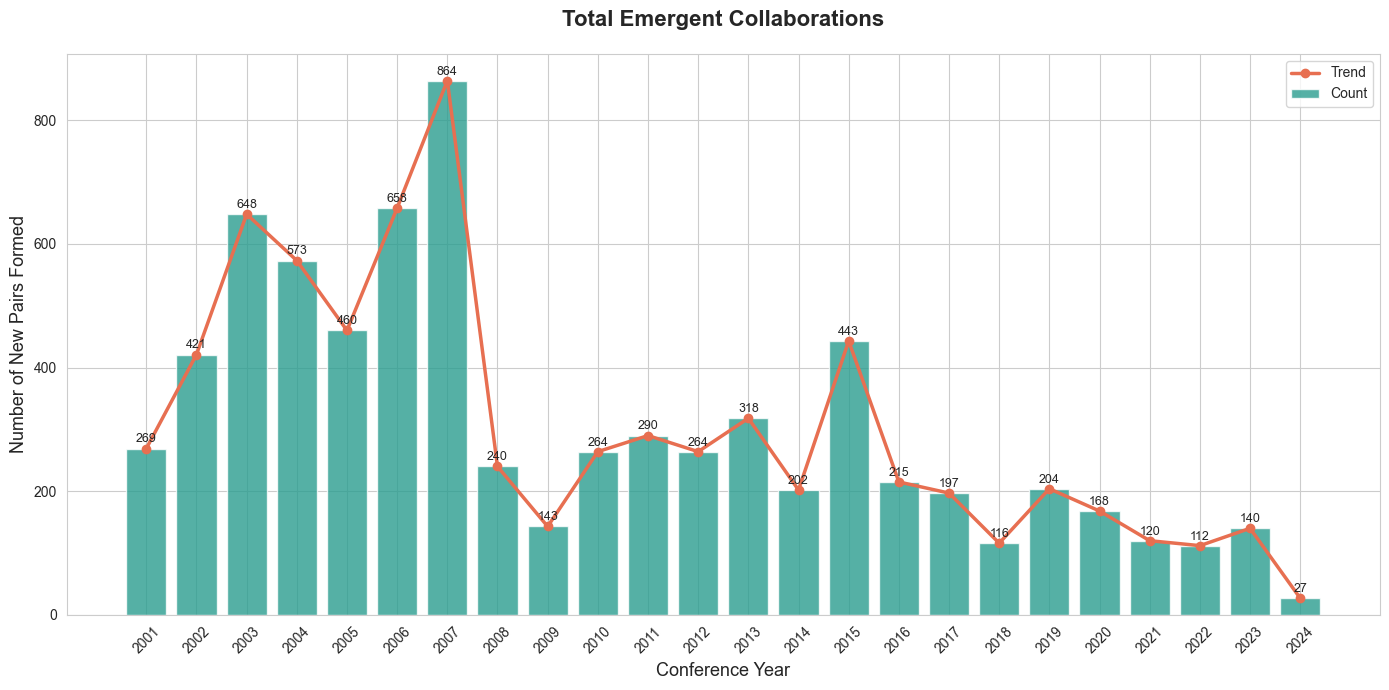

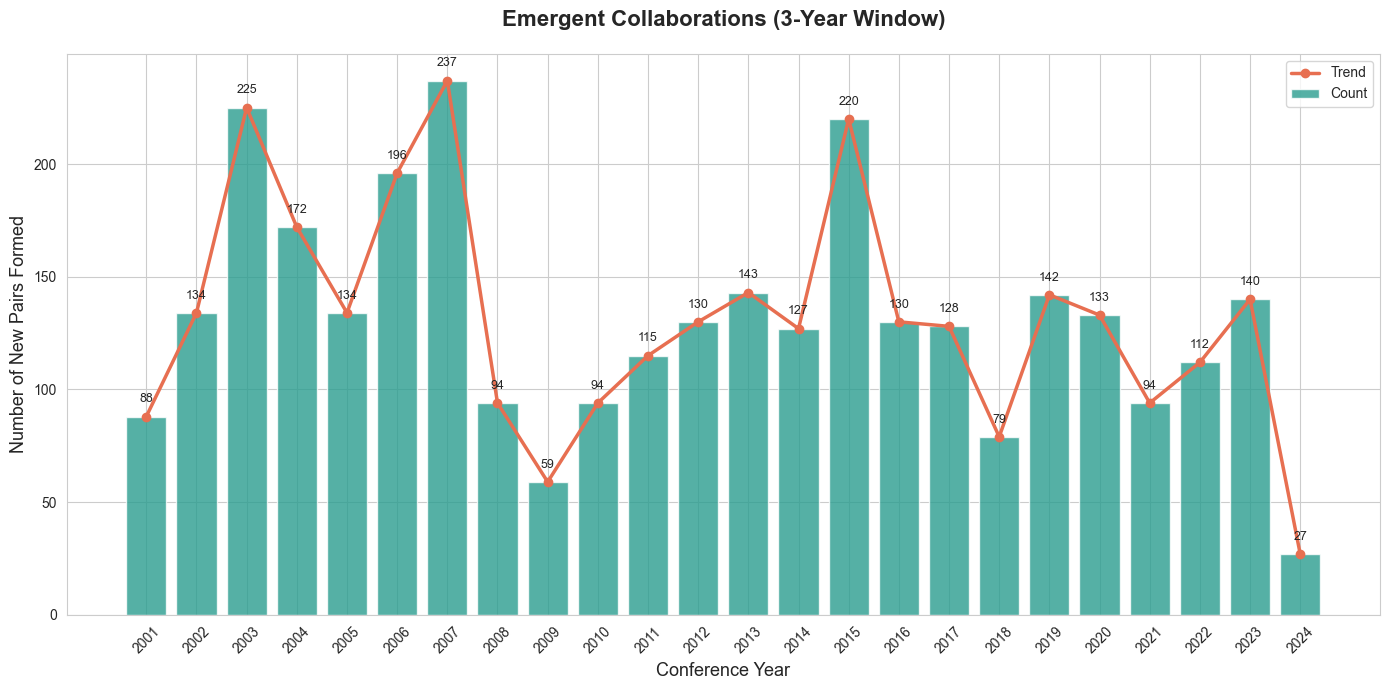

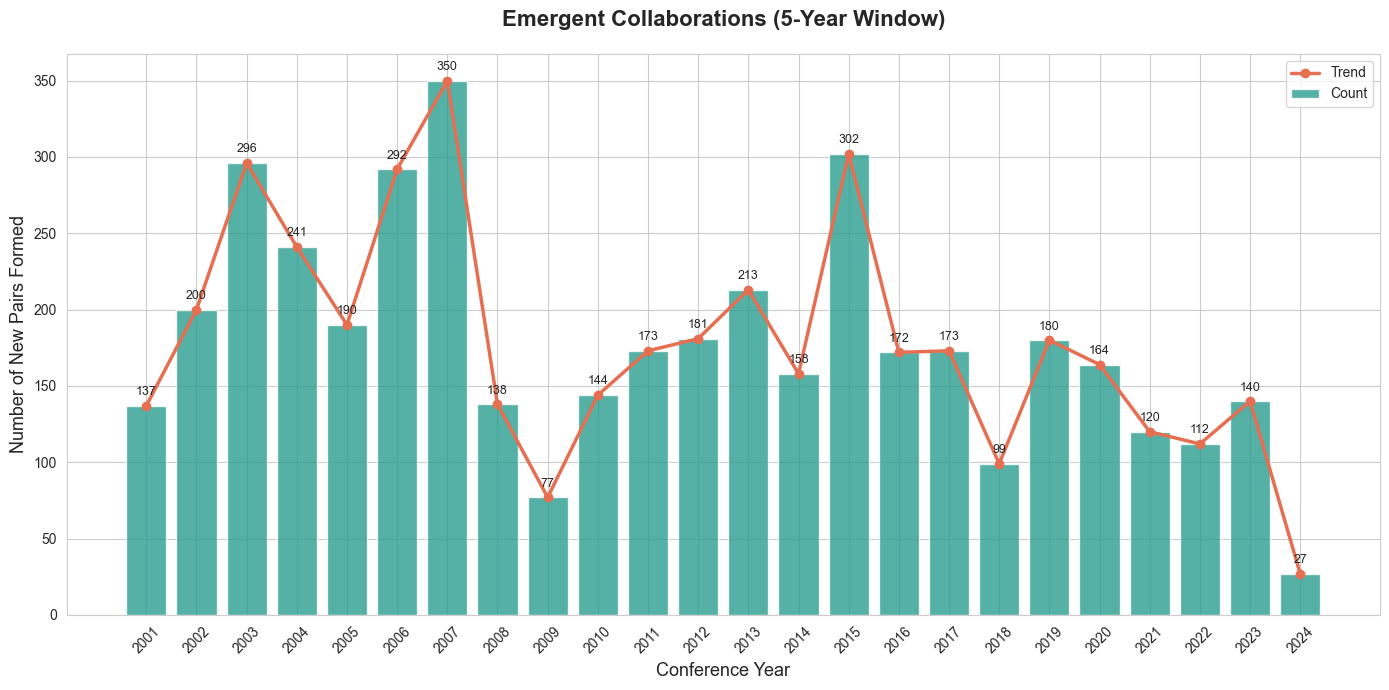

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_emergent_trends(table_name, title):

    query = f"SELECT event_year, COUNT(*) AS n_pairs FROM {table_name} GROUP BY 1 ORDER BY 1"
    df = con.execute(query).fetchdf()

    plt.figure(figsize=(14, 7))
    sns.set_style("whitegrid")
    bars = plt.bar(df['event_year'], df['n_pairs'], color='#2a9d8f', alpha=0.8, label='Count')
    plt.plot(df['event_year'], df['n_pairs'], color='#e76f51', marker='o', linewidth=2.5, label='Trend')
    plt.title(title, fontsize=16, fontweight='bold', pad=20)
    plt.xlabel('Conference Year', fontsize=13)
    plt.ylabel('Number of New Pairs Formed', fontsize=13)
    plt.xticks(df['event_year'], rotation=45)
    plt.legend()
    for bar in bars:
        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 5,
                 f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()

tasks = [
    ("emergent_pairs_rep", "Total Emergent Collaborations"),
    ("emergent_pairs_rep_3y", "Emergent Collaborations (3-Year Window)"),
    ("emergent_pairs_rep_5y", "Emergent Collaborations (5-Year Window)")
]

for table, title in tasks:
    plot_emergent_trends(table, title)

In [32]:
# %% [markdown]
# ## Train/Test tables (3y / 5y)
# Train: cohorts with event_year <= split_year
# Test: cohorts with complete follow-up AND event_year > split_year

# %%
splits = {
    "3y": {"split": split_year_3y, "max_test": max_complete_3y},
    "5y": {"split": split_year_5y, "max_test": max_complete_5y}
}

for w, config in splits.items():
    split = config["split"]
    max_test = config["max_test"]
    
    con.execute(f"DROP TABLE IF EXISTS train_pairs_{w}")
    con.execute(f"DROP TABLE IF EXISTS test_pairs_{w}")

    con.execute(f"""
    CREATE TABLE train_pairs_{w} AS
    SELECT author1_id, author2_id, event_year, label
    FROM pairs_labeled_{w}
    WHERE event_year <= {split}
    """)

    con.execute(f"""
    CREATE TABLE test_pairs_{w} AS
    SELECT author1_id, author2_id, event_year, label
    FROM pairs_labeled_{w}
    WHERE event_year > {split} AND event_year <= {max_test}
    """)

    print(f"{w} TRAIN/TEST (censoring-aware)")
    result = con.execute(f"""
    SELECT
      (SELECT COUNT(*) FROM train_pairs_{w}) AS train_n,
      (SELECT SUM(label) FROM train_pairs_{w}) AS train_pos,
      (SELECT COUNT(*) FROM test_pairs_{w}) AS test_n,
      (SELECT SUM(label) FROM test_pairs_{w}) AS test_pos,
      (SELECT MIN(event_year) FROM test_pairs_{w}) AS test_min_year,
      (SELECT MAX(event_year) FROM test_pairs_{w}) AS test_max_year
    """).fetchdf()
    print(result)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

3y TRAIN/TEST (censoring-aware)
    train_n  train_pos   test_n  test_pos  test_min_year  test_max_year
0  10274198     2647.0  1562882     479.0           2020           2023


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

5y TRAIN/TEST (censoring-aware)
   train_n  train_pos   test_n  test_pos  test_min_year  test_max_year
0  9629842     3437.0  1566862     563.0           2018           2021


In [33]:
con.execute("""
SHOW TABLES
""").fetchdf()


,name
0,authors
1,coauthorship_edges
2,emergent_pairs
3,emergent_pairs_rep
4,emergent_pairs_rep_3y
5,emergent_pairs_rep_5y
6,first_coauth_year
7,iccs_authors_per_year
8,iccs_born_sustained
9,iccs_coattend_pairs


In [36]:
con = duckdb.connect(str(NEW_DB_PATH))
con.execute("SET threads = 4")

In [ ]:
con.close()

: 